In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import time
import os
from scipy.misc import imread
import matplotlib.pyplot as plt
%matplotlib inline

## Load Training and Testing Sets

In [3]:
SIZE = 28
images = []
labels = []

type_labels = {'individual': [1, 0, 0], 'tandem': [0, 1, 0], 'transport': [0, 0, 1]}

for img_type in type_labels:
    path = os.path.join('ant_img_gs', img_type)
    for img_file in os.listdir(path):
        if img_file.endswith('.png'):
            im = imread(os.path.join(path, img_file)).flatten()
            if im.size != SIZE * SIZE:
                continue

            images.append(im)
            labels.append(type_labels[img_type])
        
images = np.asarray(images)
labels = np.asarray(labels)

In [4]:
perm = np.random.permutation(len(images))
shuffled_images = images[perm]
shuffled_labels = labels[perm]

In [5]:
training_size = len(images) * 9 // 10

training_images = shuffled_images[:training_size]
training_labels = shuffled_labels[:training_size]

test_images = shuffled_images[training_size:]
test_labels = shuffled_labels[training_size:]

## Model

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [8]:
# CNN
x = tf.placeholder(tf.float32, shape=[None, SIZE*SIZE])
y_ = tf.placeholder(tf.float32, [None, 3])

with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, SIZE, SIZE, 1])
    
with tf.name_scope('conv'):
    W_conv = weight_variable([3, 3, 1, 8])
    b_conv = bias_variable([8])
    h_conv = tf.nn.relu(tf.nn.conv2d(x_image, W_conv, strides=[1, 1, 1, 1], padding='SAME'))
    
with tf.name_scope('pool'):
    h_pool = tf.nn.max_pool(h_conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
with tf.name_scope('fc1'):
    W_fc1 = weight_variable([SIZE//2*SIZE//2*8, 100])
    b_fc1 = bias_variable([100])
        
    h_pool_flat = tf.reshape(h_pool, [-1, SIZE//2*SIZE//2*8])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
    
with tf.name_scope('fc2'):
    W_fc2 = weight_variable([100, 3])
    b_fc2 = bias_variable([3])

    y = tf.matmul(h_fc1, W_fc2) + b_fc2
    

In [9]:
saver = tf.train.Saver()

## Training

In [10]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    

In [13]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

start_time = time.time()
steps = 2000
for i in range(steps):
    if (i+1) % 100 == 0:
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        delta_time = time.time() - start_time
        time_message = '{} s'.format(int(delta_time)) if delta_time > 1 else '{} ms'.format(int(delta_time * 1000))
        
        print('{}/{} Training accuracy {}. {}'.format(i+1, steps, sess.run(accuracy, feed_dict={x: training_images, y_: training_labels}),
                                                time_message))
        start_time = time.time()
        
        saver.save(sess, 'tf_save/trained_model.ckpt')
    
    sess.run(train_step, feed_dict={x: images, y_: labels})

100/2000 Training accuracy 0.6838445663452148. 23 s
200/2000 Training accuracy 0.7567914128303528. 23 s
300/2000 Training accuracy 0.8050535321235657. 23 s
400/2000 Training accuracy 0.8359623551368713. 23 s
500/2000 Training accuracy 0.8575880527496338. 23 s
600/2000 Training accuracy 0.8740445971488953. 23 s
700/2000 Training accuracy 0.8873364925384521. 24 s
800/2000 Training accuracy 0.9012613296508789. 23 s
900/2000 Training accuracy 0.912548840045929. 23 s
1000/2000 Training accuracy 0.9214627742767334. 23 s
1100/2000 Training accuracy 0.9295855760574341. 23 s
1200/2000 Training accuracy 0.9362315535545349. 23 s
1300/2000 Training accuracy 0.941558837890625. 24 s
1400/2000 Training accuracy 0.9477827548980713. 23 s
1500/2000 Training accuracy 0.9530573487281799. 23 s
1600/2000 Training accuracy 0.958806574344635. 23 s
1700/2000 Training accuracy 0.963395357131958. 23 s
1800/2000 Training accuracy 0.9671403169631958. 23 s
1900/2000 Training accuracy 0.97135990858078. 23 s
2000/200

In [14]:
print('Test accuracy {}'.format(sess.run(accuracy, feed_dict={x: test_images, y_:test_labels})))

Test accuracy 0.9738965630531311


## Session Restore

In [15]:
sess = tf.Session()
saver.restore(sess, 'tf_save/trained_model.ckpt')

INFO:tensorflow:Restoring parameters from tf_save/trained_model.ckpt


## Application

### Load image

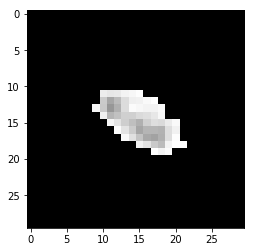

In [58]:
img = imread('test_patches/ants.png')
plt.imshow(img, 'gray')

In [59]:
sess.run(tf.argmax(y, 1), feed_dict={x: [img.flatten()]})

array([2])